<a href="https://colab.research.google.com/github/armandordorica/Advanced-Python/blob/master/a_b_tester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B testing notes

* Sample Size calculator https://www.evanmiller.org/ab-testing/sample-size.html

* **Type I error rate** = alpha = Probability that you reject the null hypothesis incorrectly (you say there was no change but there actually was) = 0.05 commonly used  --> Confidence level = Probability of NOT making type I error
* **Type II error rate** = beta = Probability to fail to reject the null hypothesis when it should be rejected (You  said there was no significant difference between test and control but there acually was)
* **Statistical power** = Probability that the test rejects the null hypothesis when it should be rejected = Probability that you say there was a significant difference between test and control and you are correct saying this = 0.8 commonly used = 1- beta (so beta is 0.2) 
    * As sample size increases, statistical power increases 
    
* **Conversion Rate**: Current conversion rate for the goal you are trying to improve (subscription rate, transaction rate, clickthrough rate)
* **Minimum Detectable Effect**: Minimum relative change in conversion rate you'd like to be able to detect. 

Multiple Testing Problem 
* E.g. There are 3 groups, what is the chance of at least one false positive? 
-> Pr(no false positive) = (1-0.05)^3 = 0.95^3 = 0.857
-> Pr(at least 1 false positive) = 1 - Pr(no false positive) = 0.143 = 14.3%


### Bonferroni correction 

Significance level for 10 tests =  significance level for one test/number of tests
 = 0.05/10 = 0.005
 

# Variable Interference 
### When can post launch effect be different from what you saw during experimentation
Spillover effect --> If we apply some treatment to someone in the test group they can tell their friends via Network effect and then your test/control populations aren't any longer identical. 

Network effect: 
* User behaviours are impacted by others 
* The effect can spillover the control group
* The difference underestimates the treatment effect


Under Two-Sided Markets (AirBnb, Lyft, Uber) 
* Actual effect < treatment effect
 
 
### Dealing With Intereference
**Two sided-markets**
* Geo-based randomization 
    * Split by geolocations, i.e. New York vs San Fran 
    * Issue --> Big variance because markets are unique 
    
* Time-based randomization 
    * Split by day of week 
    * Assign all users to either treatment or control 
    * Only when treatment effect is in short time (no lag)
    * Works only when the treatment effect lasts in short time (e.g. Uber's surge price)
    * Does not work when the treatment effect takes a long time (i.e. referral program)


When to use binomial distribution? 
* 2 types of outcomes (success and failure, bernoulli)
* Independent events 
* Identical distribution 

In [1]:
from scipy.stats import norm
from scipy import stats
import math 
import matplotlib.pyplot as plt
import numpy as np

def get_p_pool(N_cont, X_cont, N_test, X_test):
    return (X_cont+X_test)/(N_cont+N_test)

def get_standard_error_pool(N_cont, X_cont, N_test, X_test):
    P_pool = get_p_pool(N_cont, X_cont, N_test, X_test)
    return  math.sqrt(P_pool*(1-P_pool)*((1/N_cont)+(1/N_test)))

def get_z_score(confidence_interval): 
    input = 1- (100-confidence_interval)/2/100
    return stats.norm.ppf(input)
    
def get_confidence_interval_users(num_users_who_click, num_total_users, conf_int_pct): 
    p_hat = num_users_who_click/num_total_users
    standard_error  = math.sqrt(p_hat*(1-p_hat)/num_total_users)
    z = get_z_score(conf_int_pct)
    m = z* standard_error
    print("Probability of success:{}".format(p_hat))
    print("Standard Error:{}".format(standard_error))
    print("Margin of Error:{}".format(m))

    lower_bound = (p_hat-m)*num_total_users
    upper_bound = (p_hat + m)*num_total_users
    
    return lower_bound, upper_bound

def get_confidence_interval_pct(num_users_who_click, num_total_users, conf_int_pct): 
    lower_bound, upper_bound = get_confidence_interval_users(num_users_who_click, num_total_users, conf_int_pct)
    
    return lower_bound/num_total_users, upper_bound/num_total_users 

def get_practical_significance(N_cont, X_cont, N_test, X_test, d_min, confidence_interval): 
    #Your experiment should be set up such that your statistically significance bar
    #is actually lower than your practically significance bar. 
    P_pool = (X_cont+X_test)/(N_cont+N_test)
    standard_error_pool = math.sqrt(P_pool*(1-P_pool)*((1/N_cont)+(1/N_test)))

    P_test = X_test/N_test
    P_cont = X_cont/N_cont 

    d_practical = P_test - P_cont

    z = get_z_score(confidence_interval)

    m = z*standard_error_pool

    d_practical_lower_bound =  d_practical - m
    d_practical_upper_bound = d_practical + m 
    
    print("D practical Lower Bound:{}".format(d_practical_lower_bound))
    print("D Practical Upper Bound:{}".format(d_practical_upper_bound))

    if d_practical_lower_bound > d_min and d_practical_upper_bound > d_min: 
        print("Detectable effect above required threshold of {}% with {}% confidence".format(d_min*100, confidence_interval ))
    
    if d_min > d_practical_upper_bound or d_min > d_practical_lower_bound: 
        print("Does not meet requirements")
    
    return d_practical_lower_bound, d_min, d_practical_upper_bound
    
def plot_significance_for_sample_size(N_cont, X_cont, N_test, X_test, d_min=0.02, confidence_interval=95):
    d_lowers = []
    d_mins = []
    d_uppers = []
    for n in range(1, 10000): 
        print("n multiplier:{}".format(n))
        d_lower, d_min, d_upper = get_practical_significance(N_cont*n, X_cont*n, N_test*n, X_test*n, d_min, confidence_interval)

        d_lowers.append(d_lower)
        d_mins.append(d_min)
        d_uppers.append(d_upper)



    ns = np.arange(1,10000)
    plt.scatter(ns, d_lowers, label='d_lowers')
    plt.scatter(ns, d_mins, label='d_min')
    plt.scatter(ns, d_uppers, label='d_uppers')
    plt.xlabel("Sample Size multiplier")
    plt.ylabel("Detectable effect")
    plt.legend()
    
def get_sample_size(N_cont, X_cont, N_test, X_test): 
    p_cont = X_cont/N_cont *100
    print(p_cont)
    p_test = X_test/N_test *100 
    print(p_test)
    
    d =(p_test - p_cont) 
    sample_size = 16* p_cont * (100-p_cont)/d**2
    return sample_size

### 300 people click on a website out of 2000 views. What are the lower and upper bounds that you should expect to see with 99% confidence interval? 

In [2]:
get_confidence_interval_users(300,2000, 99)

Probability of success:0.15
Standard Error:0.007984359711335657
Margin of Error:0.020566347714533625


(258.8673045709328, 341.1326954290672)

### Practical Significance of a Test/Control Experiment

In [3]:
get_practical_significance(10072, 974, 9886, 1242, 0.02, 95)

D practical Lower Bound:0.020210660302896456
D Practical Upper Bound:0.03764628777733894
Detectable effect above required threshold of 2.0% with 95% confidence


(0.020210660302896456, 0.02, 0.03764628777733894)

### Out of 100 accounts with the same fraud score (iid), 10 are fraud. How many would you expect to see fraudulent in the next batch? 
Between 4 and 15

In [4]:
get_confidence_interval_users(10,100, 95)

Probability of success:0.1
Standard Error:0.030000000000000002
Margin of Error:0.05879891953620162


(4.120108046379838, 15.879891953620163)

In [5]:
N_cont = 100
X_cont = 1 
N_test = 20 
X_test = 1


In [6]:
get_p_pool(N_cont, X_cont, N_test, X_test)

0.016666666666666666

In [7]:
get_standard_error_pool(N_cont, X_cont, N_test, X_test)

0.031358146203711294

### Calculate Necessary Sample Size 

* Control Group:
    * Sent:140000
    * Converted: 6000
    * Conversion Rate: 0.0429

* Test/Treatment Group:
    * Sent:350000
    * Converted:19000
    * Conversion Rate: 0.0543

In [8]:
N_cont = 140000
X_cont = 6000
N_test = 350000
X_test = 19000
get_sample_size(N_cont, X_cont, N_test, X_test)

4.285714285714286
5.428571428571429


5024.999999999996

Streaming output truncated to the last 5000 lines.
n multiplier:8750
D practical Lower Bound:0.011282775812538764
D Practical Upper Bound:0.01157436704460409
Does not meet requirements
n multiplier:8751
D practical Lower Bound:0.01128278414300279
D Practical Upper Bound:0.011574358714140063
Does not meet requirements
n multiplier:8752
D practical Lower Bound:0.011282792472039022
D Practical Upper Bound:0.011574350385103831
Does not meet requirements
n multiplier:8753
D practical Lower Bound:0.011282800799647868
D Practical Upper Bound:0.011574342057494986
Does not meet requirements
n multiplier:8754
D practical Lower Bound:0.011282809125829735
D Practical Upper Bound:0.011574333731313119
Does not meet requirements
n multiplier:8755
D practical Lower Bound:0.011282817450585032
D Practical Upper Bound:0.011574325406557822
Does not meet requirements
n multiplier:8756
D practical Lower Bound:0.011282825773914163
D Practical Upper Bound:0.01157431708322869
Does not meet requirements
n multi

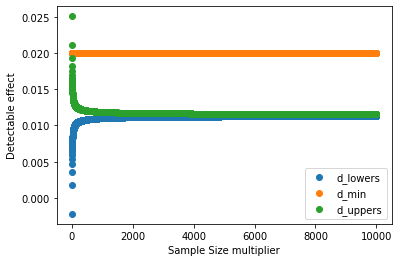

In [9]:
N_cont = 1400
X_cont = 60
N_test = 3500
X_test = 190
# plot_significance_for_sample_size(N_cont, X_cont, N_test, X_test, d_min=0.02, confidence_interval=95)

Streaming output truncated to the last 5000 lines.
n multiplier:8750
D practical Lower Bound:0.2776103801565116
D Practical Upper Bound:0.27953247698634553
Detectable effect above required threshold of 2.0% with 95% confidence
n multiplier:8751
D practical Lower Bound:0.2776104350688572
D Practical Upper Bound:0.279532422074
Detectable effect above required threshold of 2.0% with 95% confidence
n multiplier:8752
D practical Lower Bound:0.2776104899717911
D Practical Upper Bound:0.27953236717106605
Detectable effect above required threshold of 2.0% with 95% confidence
n multiplier:8753
D practical Lower Bound:0.277610544865316
D Practical Upper Bound:0.27953231227754116
Detectable effect above required threshold of 2.0% with 95% confidence
n multiplier:8754
D practical Lower Bound:0.27761059974943464
D Practical Upper Bound:0.2795322573934225
Detectable effect above required threshold of 2.0% with 95% confidence
n multiplier:8755
D practical Lower Bound:0.27761065462414963
D Practical U

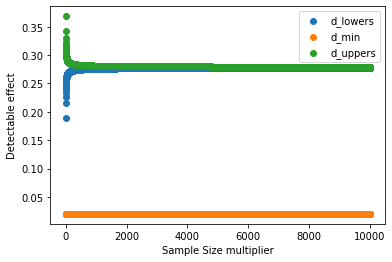

In [10]:
N_cont = 140
X_cont = 1
N_test = 35
X_test = 10
get_practical_significance(N_cont, X_cont, N_test, X_test, 0.2, 95)

# plot_significance_for_sample_size(N_cont, X_cont, N_test, X_test, d_min=0.02, confidence_interval=95)

In [11]:
N_cont = 140000
X_cont = 6000
N_test = 350000
X_test = 19000
get_sample_size(N_cont, X_cont, N_test, X_test)

4.285714285714286
5.428571428571429


5024.999999999996

In [12]:
get_practical_significance(1595, 68, 3905, 211, 0.02, 95)

D practical Lower Bound:-0.0013806438048493234
D Practical Upper Bound:0.02418076743061646
Does not meet requirements


(-0.0013806438048493234, 0.02, 0.02418076743061646)

Streaming output truncated to the last 5000 lines.
n multiplier:8750
D practical Lower Bound:0.011263430322647074
D Practical Upper Bound:0.011536693303120064
Detectable effect above required threshold of 1.0% with 95% confidence
n multiplier:8751
D practical Lower Bound:0.011263438129491649
D Practical Upper Bound:0.011536685496275489
Detectable effect above required threshold of 1.0% with 95% confidence
n multiplier:8752
D practical Lower Bound:0.011263445934998177
D Practical Upper Bound:0.011536677690768962
Detectable effect above required threshold of 1.0% with 95% confidence
n multiplier:8753
D practical Lower Bound:0.011263453739167038
D Practical Upper Bound:0.0115366698866001
Detectable effect above required threshold of 1.0% with 95% confidence
n multiplier:8754
D practical Lower Bound:0.011263461541998615
D Practical Upper Bound:0.011536662083768523
Detectable effect above required threshold of 1.0% with 95% confidence
n multiplier:8755
D practical Lower Bound:0.011263469343

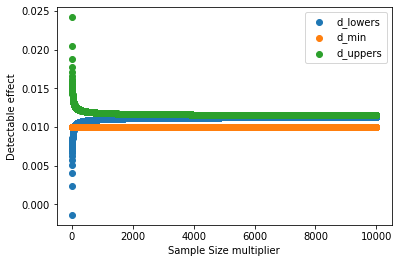

In [13]:
N_cont = 1595
X_cont = 68
N_test = 3905
X_test = 211

# plot_significance_for_sample_size(N_cont, X_cont, N_test, X_test, d_min=0.01, confidence_interval=95)